### Libs

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel

In [2]:
stop_words = set(stopwords.words('english')).union(['eg', 'etc', 'ie'])
lemmatizer = WordNetLemmatizer()

In [3]:
def preprocess(documents):
    preprocessed_docs = []
    # Для каждлго документа в наборе
    for doc in documents:
        # Удаление знаков препинания
        doc = re.sub(r'[^\w\s]', '', doc)
        # Токенизация документа
        tokens = word_tokenize(doc.lower())
        # Удаление стоп-слов
        tokens = [token for token in tokens if token not in stop_words]
        # Лемматизация токенов (приведение к начальной форме)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # Добавление предобработанных токенов в список
        preprocessed_docs.append(lemmatized_tokens)
    return preprocessed_docs

def extract_keywords_tfidf(documents, n=10):
    # Предобработка текстовых данных
    preprocessed_docs = preprocess(documents)
    # Создание словаря
    dictionary = corpora.Dictionary(preprocessed_docs)
    # Создание корпуса как список мешков слов
    corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
    # Обучение модели TF-IDF
    tfidf = TfidfModel(corpus)
    tfidf_scores = {}
    # Для каждого документа в корпусе
    for i, doc in enumerate(corpus):
        doc_tfidf = tfidf[doc]
        # Для каждого термина в документе
        for term_id, score in doc_tfidf:
            # Получение термина по его идентификатору
            term = dictionary.get(term_id)
            # Если термин еще не встречался, то добавить его в словарь
            if term not in tfidf_scores:
                tfidf_scores[term] = score
            # Иначе добавить к существующему значению
            else:
                tfidf_scores[term] += score
    # Сортировка терминов по убыванию веса
    sorted_terms = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    return [term for term, score in sorted_terms[:n]]

def extract_keywords_lda(documents, n=10):
    # Предобработка текстовых данных
    preprocessed_docs = preprocess(documents)
    # Создание словаря
    dictionary = corpora.Dictionary(preprocessed_docs)
    # Создание корпуса как список мешков слов
    corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
    # Обучение модели LDA
    lda = LdaModel(corpus, num_topics=1, id2word=dictionary)
    # Извлечение ключевых слов
    topic_terms = lda.print_topics()[0][1]
    # Разбиение на список терминов и их весов
    topic_terms = [term.split('*')[1].strip().replace('"', '') for term in topic_terms.split('+')]
    return topic_terms[:n]

### Load & Prepare

In [4]:
patents = pd.read_csv('patents.csv')
classes = patents['IPC'].unique()
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "black", "gray"]
for class_ in classes:
    print(class_, patents[patents['IPC'] == class_].shape[0])

G05B 10682
G11B 10682
H01L 10682
H04M 10682


In [5]:
X = patents["Title"]
y = patents["IPC"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [8]:
print(f"Размерность вектора: {X_train_vectors.shape[1]}")

Размерность вектора: 15571


## Logistic Regression Classifier

In [7]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    random_state=42,
    max_iter=1000,
)
print("Training the classifier...")
clf.fit(X_train_vectors, y_train)
print("Evaluating...")
y_pred_lr = clf.predict(X_test_vectors)
print("Done!")

Training the classifier...
Evaluating...
Done!


In [8]:
print("Logistic Regression Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classifier
Accuracy: 0.87
              precision    recall  f1-score   support

        G05B       0.81      0.85      0.83      2180
        G11B       0.88      0.87      0.88      2147
        H01L       0.93      0.90      0.92      2101
        H04M       0.85      0.84      0.85      2118

    accuracy                           0.87      8546
   macro avg       0.87      0.87      0.87      8546
weighted avg       0.87      0.87      0.87      8546



### Plot

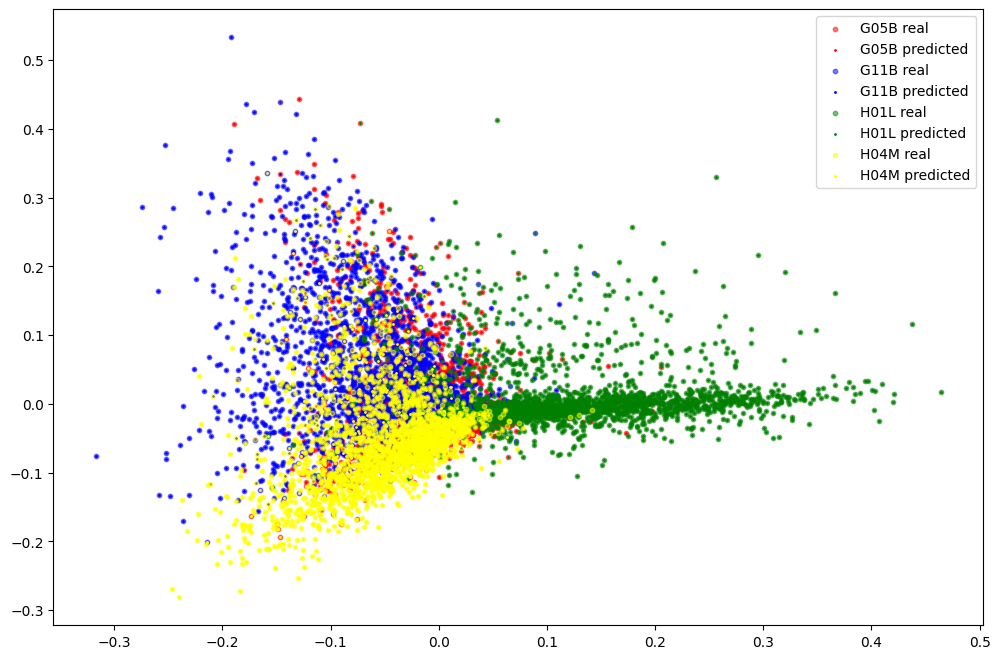

In [9]:
# plot 2d data using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_test_vectors.toarray())

plt.figure(figsize=(12, 8))

for label, color in zip(classes, colors):
    plt.scatter(X_pca[y_test == label, 0], X_pca[y_test == label, 1], label=f"{label} real", alpha=0.5, s=10, c=color)
    plt.scatter(X_pca[y_pred_lr == label, 0], X_pca[y_pred_lr == label, 1], label=f"{label} predicted", alpha=1, s=1, c=color)

plt.legend()
plt.show()

### Topic Extract

In [10]:
# get the top 10 keywords for each cluster
for class_ in np.unique(y_pred_lr):
    print(f"Cluster {class_}")
    print('    ', ' '.join(extract_keywords_lda(X_test[y_pred_lr == class_])))

Cluster G05B
     system data method control involves device information based unit process
Cluster G11B
     data information medium content device method recording file audio video
Cluster H01L
     circuit involves semiconductor method integrated device layout data pattern design
Cluster H04M
     information method mobile involves system terminal user data device communication


## K-Means Clustering

In [11]:
# Clustering with K-Means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
print("Training the classifier...")
kmeans.fit(X_train_vectors)
print("Evaluating...")
y_pred_km = kmeans.predict(X_test_vectors)
print("Done!")

# Сопоставление кластеров с классами
cluster_labels = {}
for cluster in np.unique(y_pred_km):
    counts = y_test[y_pred_km == cluster].value_counts()
    class_probas = counts / counts.sum()
    print(f"Cluster {cluster} probabilities: {[f'{class_}: {proba:.2f}' for class_, proba in zip(class_probas.index, class_probas.values)]}")
    cluster_labels[cluster] = class_probas.index[0]
y_pred_km = np.array([cluster_labels[cluster] for cluster in y_pred_km])

Training the classifier...
Evaluating...
Done!
Cluster 0 probabilities: ['H04M: 0.46', 'G11B: 0.37', 'G05B: 0.14', 'H01L: 0.03']
Cluster 1 probabilities: ['H01L: 0.97', 'G05B: 0.01', 'G11B: 0.01', 'H04M: 0.00']
Cluster 2 probabilities: ['G05B: 0.33', 'H04M: 0.26', 'G11B: 0.22', 'H01L: 0.18']
Cluster 3 probabilities: ['G11B: 0.47', 'G05B: 0.25', 'H04M: 0.19', 'H01L: 0.09']


In [12]:
print("K-Means Clustering")
print(f"Accuracy: {accuracy_score(y_test, y_pred_km):.2f}")
print(classification_report(y_test, y_pred_km))

K-Means Clustering
Accuracy: 0.45
              precision    recall  f1-score   support

        G05B       0.33      0.79      0.47      2180
        G11B       0.47      0.24      0.32      2147
        H01L       0.97      0.49      0.65      2101
        H04M       0.46      0.27      0.34      2118

    accuracy                           0.45      8546
   macro avg       0.56      0.45      0.45      8546
weighted avg       0.56      0.45      0.45      8546



### Plot

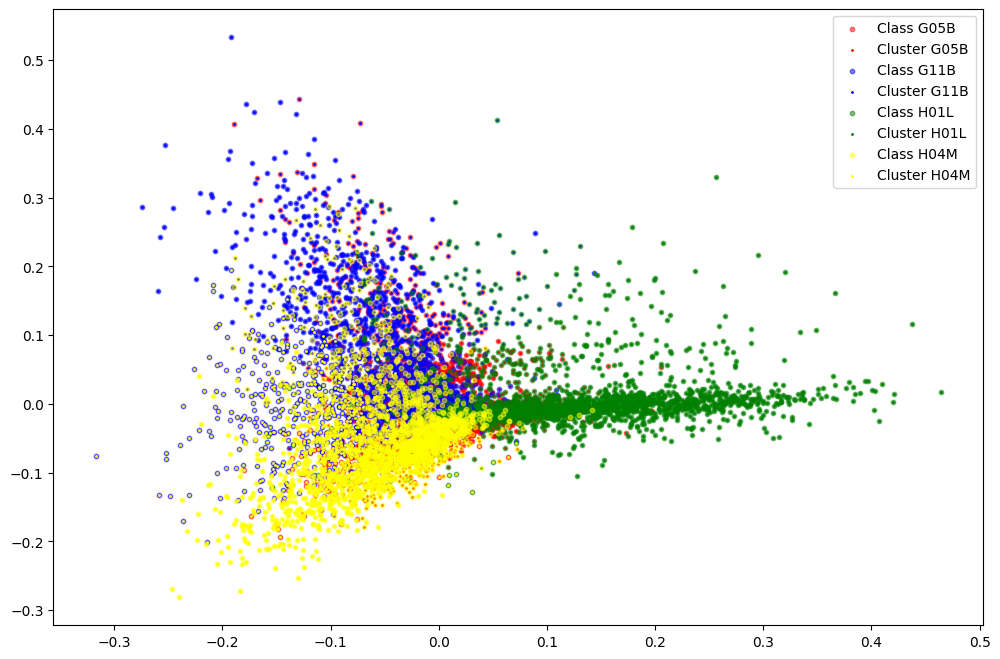

In [13]:
# plot 2d data using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_test_vectors.toarray())
plt.figure(figsize=(12, 8))

for label, color in zip(classes, colors):
    plt.scatter(X_pca[y_test == label, 0], X_pca[y_test == label, 1], c=color, label=f"Class {label}", alpha=0.5, s=10)
    plt.scatter(X_pca[y_pred_km == label, 0], X_pca[y_pred_km == label, 1], c=color, label=f"Cluster {label}", alpha=1, s=1)

plt.legend()
plt.show()

## Topic Extract

In [14]:
# get the top 10 keywords for each cluster
for cluster in np.unique(y_pred_km):
    print(f"Cluster {cluster}")
    print('    ', ' '.join(extract_keywords_tfidf(X_test[y_pred_km == cluster])))

Cluster G05B
     device system control method involves unit signal process based user
Cluster G11B
     device unit recording system file storage processing method information medium
Cluster H01L
     wiring cell layout pattern design device semiconductor logic delay data
Cluster H04M
     content device terminal unit recording apparatus user system processing display


## Hierarchical Clustering

In [15]:
# Clustering with Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=4)
print("Training the classifier...")
hierarchical.fit(X_train_vectors.toarray())
print("Evaluating...")
y_pred_hc = hierarchical.fit_predict(X_test_vectors.toarray())

# match cluster numbers and class labels for most IPC inclusions
cluster_labels = {}
for cluster in np.unique(y_pred_hc):
    cluster_labels[cluster] = y_test[y_pred_hc == cluster].mode()[0]

y_pred_hc = np.array([cluster_labels[cluster] for cluster in y_pred_hc])

print("Hierarchical Clustering")
print(f"Accuracy: {accuracy_score(y_test, y_pred_hc):.2f}")
print(classification_report(y_test, y_pred_hc))

Training the classifier...


## Spectral Clustering

In [6]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=4, random_state=42)
print("Training the classifier...")
spectral.fit(X_train_vectors)
print("Evaluating...")
y_pred_sc = spectral.fit_predict(X_test_vectors)

# match cluster numbers and class labels for most IPC inclusions
cluster_labels = {}
for cluster in np.unique(y_pred_sc):
    cluster_labels[cluster] = y_test[y_pred_sc == cluster].mode()[0]

y_pred_sc = np.array([cluster_labels[cluster] for cluster in y_pred_sc])

print("Spectral Clustering")
print(f"Accuracy: {accuracy_score(y_test, y_pred_sc):.2f}")
print(classification_report(y_test, y_pred_sc))

Training the classifier...
Evaluating...
Spectral Clustering
Accuracy: 0.53
              precision    recall  f1-score   support

        G05B       0.37      0.83      0.51      1220
        G11B       0.60      0.66      0.63      1189
        H01L       0.96      0.63      0.76      1226
        H04M       0.00      0.00      0.00      1208

    accuracy                           0.53      4843
   macro avg       0.48      0.53      0.47      4843
weighted avg       0.48      0.53      0.48      4843



c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_